In [1]:
library("ape")
library("nlme")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks nlme::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::map()      masks maps::map()
✖ dplyr::select()   masks MASS::select()
✖ dplyr::where()    masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    rownames(df) <- df$species
    df$log_u <- log10(df$u_mean)
    df$log_u_year <- log10(df$u_mean_year)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.gen)
    df$log_gen_year <- log10(df$generation_time_year)
    df = dplyr::select(df, species, log_u, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return(df)
}

load_tree_and_modify_species_name <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    # the tree should be both binary and ultrametric
    stopifnot(is.binary(tree)) 
    stopifnot(is.ultrametric(tree))
    # 126 species, 250 edges
    length(tree$tip.label) 
    # plot(tree)
    
    # replace all _ in tree species name to space
    for(nn in tree$tip.label){
      tmp <- stringr::str_replace_all(nn,'_', ' ')
      tree$tip.label <- 
        stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}


pgls_dbh <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_abline(intercept = intercept, slope = slope) + geom_smooth(formula=y~x, method="lm")
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Load Wang's vertebrate data and tree 

In [3]:
# df <- load_and_process_csv("./output/processed_mutation_rate_estimate.csv")
df <- load_and_process_csv("./output/df_vertebrate.csv")

tree_filename <- "./data/filtered_unique_species.nwk"
orig_tree <- load_tree_and_modify_species_name(tree_filename)
new_tree <- trim_tree_branches(orig_tree, df)

## Figure 2: Perform PGLS on gamete mutation rate per site per year and early embryonic mutation rate per site per generation on generation time (year)

In [9]:
create_gamete_and_embroynic_mutation_rate_dataframe <- function(csv_filename, remove_ayeaye=FALSE, add_dog=FALSE) {
    # human,  rhesus macaque, owl monkey, cat, mouse, chimpanzee, baboon, aye-aye (gray mouse lemur), dog
    columnHeaders <- c("species", "species2", "gen", "intercept", "slope", "mu_gen")
    # csv_filename <- "output/figure2_point_estimates_Wang_Wang.csv"
    df <- read.csv(csv_filename, header=FALSE, skip=1, col.names=columnHeaders)
    if (remove_ayeaye) {
        df <- df[df$species != "Microcebus_murinus",]
    }
    if (add_dog) {
        dog_df <- data.frame(species="Canis_lupus_familiaris", species2="Dog", gen=4, intercept=3.75e-9, slope=4.5e-10, mu_gen=5.1e-9)
        df <- rbind(df, dog_df)
    }


    df$log_slope <- log10(df$slope)
    df$log_intercept <- log10(df$intercept)
    df$log_gen <- log10(df$gen)
    df$log_mu_gen <- log10(df$mu_gen)
    rownames(df) <- df$species
    return(df)
}

parse_dataset_name <- function(filename, remove_ayeaye=FALSE) {
    file_basename <- basename(filename)
    file_no_ext <- strsplit(file_basename, "\\.")[[1]][1]
    file_split <- strsplit(file_no_ext, "_")[[1]]
    if (remove_ayeaye == FALSE) {
        dataset_name <- paste(file_split[4], "_", file_split[5], sep="")
    } else {
        dataset_name <- paste(file_split[4], "_no_ayeaye", sep="")
    }
    return(dataset_name)
}

parse_alpha_value <- function(filename) {
    file_basename <- basename(filename)
    file_no_ext <- strsplit(file_basename, "\\.")[[1]][1]
    file_split <- strsplit(file_no_ext, "_")[[1]]
    alpha_value <- paste(file_split[6], "_", file_split[7], sep="")
    return(alpha_value)
}

pgls_nlme <- function(df, tree, x_name, y_name, print_plot) {
    fm <- as.formula(paste(y_name, "~", x_name))
    corr <- corPagel(0.5, tree, form= ~ species, fixed=FALSE)
    model <- gls(model=fm, df, correlation=corr) #, fixed=FALSE), method="ML")

    model_summary = summary(model)
    corStruct = model_summary$modelStruct$corStruct
    lambda = coef(corStruct)
    if (lambda < 0) {
        corr <- corPagel(0, tree, form= ~ species, fixed=TRUE)
        model <- gls(model=fm, df, correlation=corr)
    }

    return(model)
}

summarize_pgls_nlme_output <- function(model, model_name, print_output) {
    model_summary <- summary(model)
    ttable <- as.data.frame(summary(model)$tTable) # type list
    pval <- ttable$p
    coef <- ttable$Value
    intercept <- coef[1]
    slope <- coef[2]
    corStruct <- model_summary$modelStruct$corStruct
    lambda <- coef(corStruct)
    if (length(coef(corStruct)) == 0) {
        lambda <- 0
    } else {
        lambda <- coef(corStruct)
    }
    if (print_output) {
        print(ttable)
        cat("lambda: ", lambda, "\n")
    }
    
    df_out <- t(data.frame(c(lambda, coef, pval)))
    colnames(df_out) <- c("lambda","intercept", "slope", "intercept.p", "slope.p")
    rownames(df_out) <- c(model_name)
    return(df_out)
}

save_combined_plgs_output_for_figure2_dataset <- function(intercept_df, slope_df, per_gen_df, output_filename) {
    df.combined <- as.data.frame(rbind(as.matrix(intercept_df), as.matrix(slope_df), as.matrix(per_gen_df)))
    write.csv(df.combined, output_filename)
}

write_ayeaye_exclusion_to_filename <- function(filename, remove_ayeaye) {
    if (remove_ayeaye) {
        filename <- paste(filename, "_no_ayeaye", ".csv", sep="")
    } else {
        filename <- paste(filename, ".csv", sep="")
    }
    return(filename)
}

perform_gamete_embroynic_data_regression <- function(filename, save_output, print_output, print_plot, remove_ayeaye=FALSE, add_dog=FALSE) {
    df <- create_gamete_and_embroynic_mutation_rate_dataframe(filename, remove_ayeaye=remove_ayeaye, add_dog=add_dog)
    dataset_name <- parse_dataset_name(filename, remove_ayeaye)
    alpha_value <- parse_alpha_value(filename)
    if(print_output) {
        cat("----- dataset name: ", dataset_name, ", alpha: ", alpha_value, " -----\n")
    }

    orig_tree <- read.tree("./data/filtered_unique_species.nwk")
    tree <- trim_tree_branches(orig_tree, df)

    if(print_output) {
        cat("--- intercept regression --- \n")
    }
    model.mu_embryonic_gen <- pgls_nlme(df, tree, "log_gen", "log_intercept", print_plot)
    model_name <- paste(dataset_name, "_mu_embryonic_vs_generation_time_", alpha_value, sep="")
    df.intercept <- summarize_pgls_nlme_output(model.mu_embryonic_gen, model_name, print_output=print_output)
    # res <- residuals(model.mu_embryonic_gen, type="pearson")
    # print(res)

    indiv_output_filename <- paste("output/r/figure2_df/individual_regressions/", dataset_name, "_intercept_regression_output_", alpha_value, ".csv", sep="")
    write.csv(df.intercept, indiv_output_filename)

    if(print_output) {
        cat("--- slope regression ---\n")
    }
    model.mu_gamete_gen <- pgls_nlme(df, tree, "log_gen", "log_slope", print_plot)
    model_name <- paste(dataset_name, "_mu_gamete_vs_generation_time_", alpha_value, sep="")
    df.slope <- summarize_pgls_nlme_output(model.mu_gamete_gen, model_name, print_output=print_output)

    indiv_output_filename <- paste("output/r/figure2_df/individual_regressions/", dataset_name, "_slope_regression_output_", alpha_value, ".csv", sep="") # , ".csv", sep="")
    write.csv(df.slope, indiv_output_filename)

    if (print_output) {
        cat("--- overall mutation rate regression --- \n")
    }
    model.mu_per_gen <- pgls_nlme(df, tree, "log_gen", "log_mu_gen", print_plot)
    model_name <- paste(dataset_name, "_mu_gen_vs_generation_time_", alpha_value, sep="")
    df.gen <- summarize_pgls_nlme_output(model.mu_per_gen, model_name, print_output=print_output)
    indiv_output_filename <- paste("output/r/figure2_df/individual_regressions/", dataset_name, "_per_gen_regression_output_", alpha_value, ".csv", sep="") #, ".csv", sep="")
    write.csv(df.gen, indiv_output_filename)

    output_filename <- paste("output/r/figure2_df/", dataset_name, "_combined_regression_output_", alpha_value, ".csv", sep="")
    save_combined_plgs_output_for_figure2_dataset(df.intercept, df.slope, df.gen, output_filename)
}

In [10]:
save_output <- TRUE
print_output <- FALSE
print_plot <- FALSE

# wang (baboon), wang. variable
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_variable_alpha.csv", save_output, print_output, print_plot, remove_ayeaye=FALSE)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_variable_alpha.csv", save_output, print_output, print_plot, remove_ayeaye=TRUE)
# 
# wang (baboon), wang, default
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_default_alpha.csv", save_output, print_output, print_plot, remove_ayeaye = FALSE)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_default_alpha.csv", save_output, print_output, print_plot, remove_ayeaye = TRUE)

# wang (baboon), versoza, variable
# no need to run remove_ayeaye again, same baboon (wang) dataset as above
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_versoza_variable_alpha.csv", lambda, print_output, print_plot, remove_ayeaye=FALSE)

# wu (baboon), wang, variable
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wu_wang_variable_alpha.csv", lambda, print_output, print_plot, remove_ayeaye=FALSE)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wu_wang_variable_alpha.csv", lambda, print_output, print_plot, remove_ayeaye=TRUE)

# wu, versoza, variable
# no need to remove ayeaye again, same baboon (wu) dataset as above
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wu_versoza_variable_alpha.csv", lambda, print_output, print_plot, remove_ayeaye = FALSE)

In [13]:
df_noayeaye <- create_gamete_and_embroynic_mutation_rate_dataframe("output/figure2_point_estimates_wang_wang_variable_alpha.csv", remove_ayeaye=TRUE, add_dog=TRUE)
print(df_noayeaye)

                                                    species       species2
Homo_sapiens_neanderthalensis Homo_sapiens_neanderthalensis          Human
Macaca_mulatta_vestita               Macaca_mulatta_vestita Rhesus_macaque
Aotus_nancymaae                             Aotus_nancymaae     Owl_monkey
Felis_catus                                     Felis_catus            Cat
Mus_musculus_musculus                 Mus_musculus_musculus          Mouse
Pan_troglodytes_troglodytes     Pan_troglodytes_troglodytes     Chimpanzee
Papio_anubis                                   Papio_anubis         Baboon
Canis_lupus_familiaris               Canis_lupus_familiaris            Dog
                                gen    intercept        slope       mu_gen
Homo_sapiens_neanderthalensis 29.00 6.603332e-09 3.631504e-10 1.241374e-08
Macaca_mulatta_vestita         8.00 3.784811e-09 4.695514e-10 5.897793e-09
Aotus_nancymaae                6.60 4.613898e-09 6.274650e-10 8.127702e-09
Felis_catus              

In [14]:
save_output <- TRUE
print_output <- TRUE
print_plot <- FALSE
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_variable_alpha.csv", save_output, print_output, print_plot, remove_ayeaye=TRUE, add_dog=TRUE)

----- dataset name:  wang_wang , alpha:  variable_alpha  -----
--- intercept regression --- 
                 Value  Std.Error    t-value      p-value
(Intercept) -8.4478644 0.08862566 -95.320746 8.983108e-11
log_gen      0.1995677 0.09281381   2.150194 7.508620e-02
lambda:  0 
--- slope regression ---
                 Value  Std.Error    t-value      p-value
(Intercept) -8.9643053 0.09639443 -92.996096 1.041657e-10
log_gen     -0.3888803 0.11118938  -3.497459 1.286604e-02
lambda:  0.7655055 
--- overall mutation rate regression --- 
                 Value Std.Error    t-value      p-value
(Intercept) -8.3596824 0.1095935 -76.279017 3.417419e-10
log_gen      0.3178746 0.1262442   2.517935 4.541361e-02
lambda:  0.9617854 


## Figure 3 regression: mutation rate per generation vs generation time


Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08811 -0.01184  0.00137  0.01160  0.06644 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.960
   lower bound : 0.000, p = 0.02006
   upper bound : 1.000, p = 4.563e-14
   95.0% CI   : (0.845, 0.986)
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  -8.296052   0.250083 -33.173 < 2.2e-16 ***
log_gen_year  0.215250   0.076931   2.798  0.006637 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02438 on 70 degrees of freedom
Multiple R-squared: 0.1006,	Adjusted R-squared: 0.08774 
F-statistic: 7.829 on 1 and 70 DF,  p-value: 0.006637 

                  Value  Std.Error    t-value      p-value
(Intercept)  -8.2959154 0.25173717 -32.954670 2.321606e-44
log_gen_year  0.2148251 0.07694737   2.791844 6.750975e-03
Correlation structure of class corPagel representing
   lambda 
0.9617607 


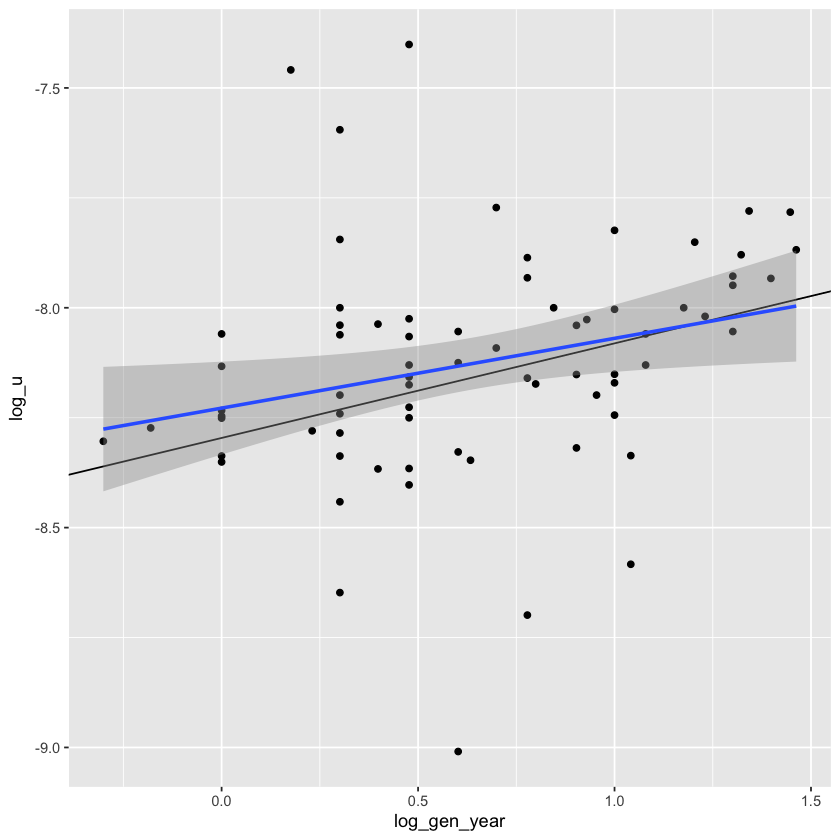

In [13]:
lambda = "ML" 
model.u_gen <- pgls_dbh(df, new_tree, "log_gen_year", "log_u", lambda=lambda, print_plot=TRUE)
summary(model.u_gen)
save_summary_data(model.u_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/mu_gen_vs_gen.csv")

model.u_gen <- pgls_nlme(df, new_tree, "log_gen_year", "log_u", print_plot=TRUE)
model_summary = summary(model.u_gen)
ttable = as.data.frame(summary(model.u_gen)$tTable)
pval = ttable$p
print(ttable)
print((model_summary$modelStruct$corStruct))

## Figure 5 regressions

### Panel A: PGLS of effective population size on generation time (year)


Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.112023 -0.024400  0.004709  0.019378  0.073704 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.944
   lower bound : 0.000, p = 0.0097167
   upper bound : 1.000, p = 5.6741e-12
   95.0% CI   : (0.658, 0.985)
delta  [Fix]  : 1.000

Coefficients:
             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)   5.39197    0.34872 15.4623 < 2.2e-16 ***
log_gen_year -0.48743    0.11257 -4.3299 4.876e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03419 on 70 degrees of freedom
Multiple R-squared: 0.2113,	Adjusted R-squared:   0.2 
F-statistic: 18.75 on 1 and 70 DF,  p-value: 4.876e-05 

                  Value Std.Error   t-value      p-value
(Intercept)   5.3925891 0.3539724 15.234492 6.411367e-24
log_gen_year -0.4878556 0.1126783 -4.329633 4.881120e-05
Correlation structure of class corPagel representing
   lambda 
0.9489679 


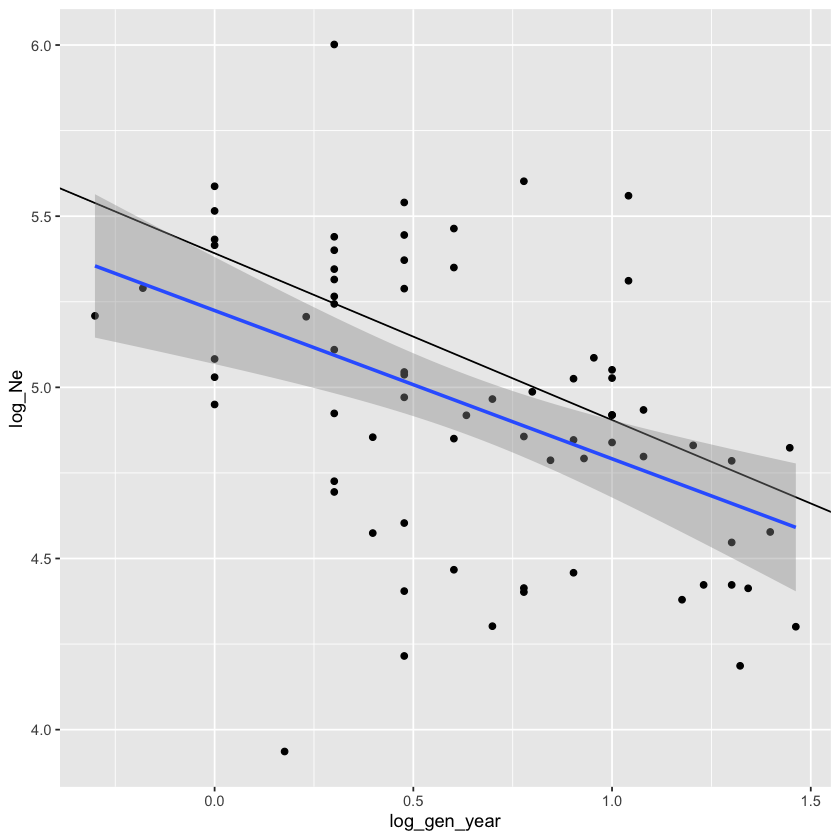

In [16]:
lambda = "ML" 
gen_Ne.pgls <- pgls_dbh(df, new_tree, "log_gen_year", "log_Ne", lambda=lambda, print_plot=TRUE)
summary(gen_Ne.pgls)

gen_Ne.pgls <- pgls_nlme(df, new_tree, "log_gen_year", "log_Ne", print_plot=TRUE)
model_summary = summary(gen_Ne.pgls)
ttable = as.data.frame(model_summary$tTable)
pval = ttable$p
print(ttable)
print((model_summary$modelStruct$corStruct))
# save_summary_data(gen_Ne.pgls, print_output=FALSE, save_output=TRUE, save_filename="output/r/Ne_vs_gen.csv")

### Panel C: perform PGLS of mutation rate per year on Ne * gen  


Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.048779 -0.018334 -0.000849  0.015202  0.064031 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.918
   lower bound : 0.000, p = 3.5409e-05
   upper bound : 1.000, p = 2.6645e-15
   95.0% CI   : (0.575, 0.982)
delta  [Fix]  : 1.000

Coefficients:
             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -4.688918   0.484059 -9.6867 1.465e-14 ***
log_Ne.gen  -0.707157   0.075437 -9.3741 5.462e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02319 on 70 degrees of freedom
Multiple R-squared: 0.5566,	Adjusted R-squared: 0.5503 
F-statistic: 87.87 on 1 and 70 DF,  p-value: 5.469e-14 

                 Value  Std.Error   t-value      p-value
(Intercept) -4.7035812 0.48829425 -9.632678 1.849555e-14
log_Ne.gen  -0.7045363 0.07561763 -9.317091 6.950748e-14
Correlation structure of class corPagel representing
   lambda 
0.9285722 


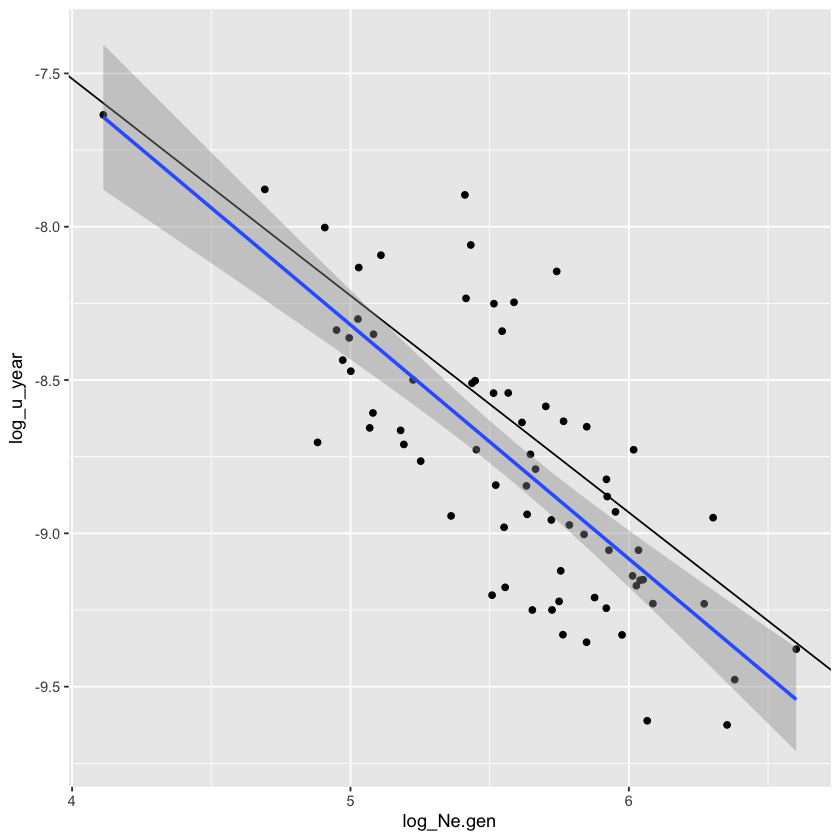

In [20]:
lambda = "ML" 
Negen_u_year.pgls <- pgls_dbh(df, new_tree, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)
# summary(Negen_u_year.pgls)
print_output=FALSE
save_output=TRUE
# save_summary_data(Negen_u_year.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_u_year_vs_Negen.csv")

# Negen_u_year.pgls <- pgls_nlme(df, new_tree, "log_Ne.gen", "log_u_year", print_plot=TRUE)
# model_summary = summary(Negen_u_year.pgls)
# ttable = as.data.frame(model_summary$tTable)
# pval = ttable$p
# print(ttable)
# print((model_summary$modelStruct$corStruct))
